# Statistical Analysis

## Imports

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pipeline import *


## Load Data

In [138]:
df_teams = pd.read_csv("dataset/cleaned/teams.csv")
df_teams_post = pd.read_csv("dataset/cleaned/teams_post.csv")

df_series_post = pd.read_csv("dataset/cleaned/series_post.csv")
df_coaches = pd.read_csv("dataset/cleaned/coaches.csv")
df_awards_players = pd.read_csv("dataset/cleaned/awards_players.csv")

aux_1 = pd.read_csv("dataset/cleaned/players.csv")
aux_2 = pd.read_csv("dataset/cleaned/players_teams.csv")

df_players = merge_player_info(aux_1, aux_2)


## Functions

In [161]:
def show_corr_matrix(df, threshold=0.7):
    # Select only the numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    correlation_matrix = numeric_df.corr()

    # Mask the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    plt.figure(figsize=(30, 16))
    sns.heatmap(correlation_matrix, annot=True,
                cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title("Correlation Matrix")
    plt.show()

    # Calculate the number of correlation values greater than the threshold in the lower triangle
    lower_triangle = correlation_matrix.where(
        np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

    num_corr_greater_than_08 = (lower_triangle > threshold).sum().sum()
    print(f"Number of correlation values greater than {threshold}:",
          num_corr_greater_than_08)

    num_corr_lower_than_08 = (lower_triangle < -threshold).sum().sum()
    print(f"Number of correlation values lower than -{threshold}:",
          num_corr_lower_than_08)


In [140]:
def show_box_plots(df):
    num_cols = int(len(df.columns)/3)+1
    num_rows = 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
    axs = axs.flatten()

    for i, col in enumerate(df.columns):

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = len(
            df[(df[col] < lower_bound) | (df[col] > upper_bound)])

        axs[i].boxplot(df[col])
        axs[i].set_ylim(df[col].min() - 0.1 * df[col].max(),
                        df[col].max() + 0.1 * df[col].max())

        axs[i].set_xlabel(f"mean: {df[col].mean():.2f}")

        if num_outliers > 40:
            axs[i].set_title(f"{col} ({num_outliers} outliers)", color='red')
        else:
            axs[i].set_title(f"{col} ({num_outliers} outliers)")

    fig.suptitle("Box Plots for Attributes")
    plt.tight_layout()
    plt.show()


In [141]:
def show_hist_plots(df):
    num_cols = int(len(df.columns)/3)+1
    num_rows = 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
    axs = axs.flatten()

    for i, col in enumerate(df.columns):
        axs[i].hist(df[col], bins=20)
        axs[i].set_xlabel(f"mean: {df[col].mean():.2f}")
        axs[i].set_title(f"{col}")

    fig.suptitle("Histograms for Attributes")
    plt.tight_layout()
    plt.show()

## Data Exploration

### Loading Original Data

In [142]:
df_teams_og = pd.read_csv("dataset/original/teams.csv")
df_teams_post_og = pd.read_csv("dataset/original/teams_post.csv")

df_series_post_og = pd.read_csv("dataset/original/series_post.csv")
df_coaches_og = pd.read_csv("dataset/original/coaches.csv")
df_awards_players_og = pd.read_csv("dataset/original/awards_players.csv")

aux_1 = pd.read_csv("dataset/original/players.csv")
aux_2 = pd.read_csv("dataset/original/players_teams.csv")

df_players_og = merge_player_info(aux_1, aux_2)

In [143]:
df_list = [df_teams_og, df_teams_post_og, df_series_post_og,
           df_coaches_og, df_awards_players_og, df_players_og]

df_list_cleaned = [df_teams, df_teams_post, df_series_post,
                   df_coaches, df_awards_players, df_players]

df_names = ["Teams", "Teams Post", "Series Post",
            "Coaches", "Awards Players", "Players"]

In [144]:
# Checking for missing values

print("Missing values in all dfs:")
for i, df in enumerate(df_list):
    print(f"{df_names[i]}: {df.isna().sum().sum()}")

# Which columns have missing values

print("\nColumns with missing values in all dfs:")
for i, df in enumerate(df_list):
    print(f"{df_names[i]}: {df.columns[df.isna().any()].tolist()}")

# Check for duplicates

print("\nDuplicates in all dfs:")
for i, df in enumerate(df_list):
    print(f"{df_names[i]}: {df.duplicated().sum()}")

# Check for columns with constant values

print("\nColumns with constant values in all dfs:")
for i, df in enumerate(df_list):
    print(f"{df_names[i]}: {df.columns[df.nunique() == 1].tolist()}")


Missing values in all dfs:
Teams: 430
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 2062

Columns with missing values in all dfs:
Teams: ['divID', 'firstRound', 'semis', 'finals']
Teams Post: []
Series Post: []
Coaches: []
Awards Players: []
Players: ['college', 'collegeOther']

Duplicates in all dfs:
Teams: 0
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 0

Columns with constant values in all dfs:
Teams: ['lgID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
Teams Post: ['lgID']
Series Post: ['lgIDWinner', 'lgIDLoser']
Coaches: ['lgID']
Awards Players: ['lgID']
Players: ['lgID', 'firstseason', 'lastseason']


## Data Cleaning Analysis

### Comparing Original Data to Cleaned Data

In [146]:
# Checking for missing values after cleaning

print("\nMissing values in all dfs (cleaned):")
for i, df in enumerate(df_list_cleaned):
    print(f"{df_names[i]}: {df.isna().sum().sum()}")

# Check for duplicates after cleaning

print("\nDuplicates in all dfs:")
for i, df in enumerate(df_list_cleaned):
    print(f"{df_names[i]}: {df.duplicated().sum()}")

# Check for columns with constant values after cleaning

print("\nColumns with constant values in all dfs:")
for i, df in enumerate(df_list_cleaned):
    print(f"{df_names[i]}: {df.columns[df.nunique() == 1].tolist()}")



Missing values in all dfs (cleaned):
Teams: 0
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 0

Duplicates in all dfs:
Teams: 0
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 0

Columns with constant values in all dfs:
Teams: []
Teams Post: []
Series Post: []
Coaches: []
Awards Players: []
Players: []


As we can see, our cleaned data is now clean of any null or irrelevant constant attributes.

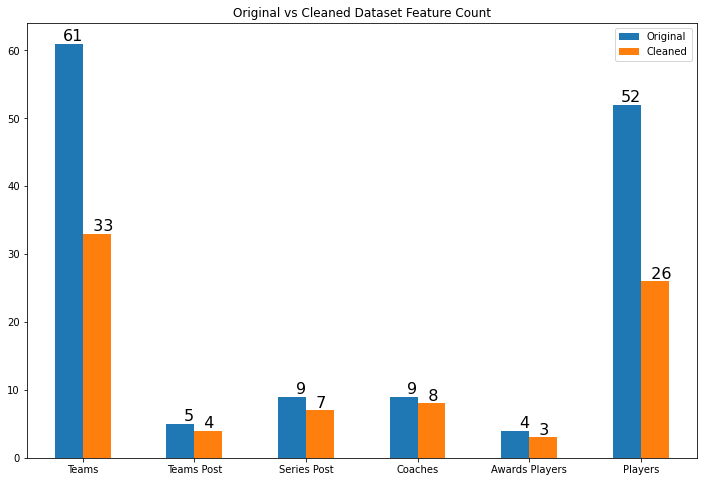

In [147]:
# Comparing the original and cleaned datasets sizes in terms of columns and rows on a graph

# Get the number of columns in each dataframe
df_sizes = [len(df.columns) for df in df_list]
df_sizes_cleaned = [len(df.columns) for df in df_list_cleaned]

# Create a DataFrame for the original and cleaned dataset sizes
df_sizes = pd.DataFrame(
    {"Original": df_sizes, "Cleaned": df_sizes_cleaned}, index=df_names)

# Create the bar plot
ax = df_sizes.plot.bar(rot=0, figsize=(12, 8))

# Add labels with numbers on top of the rectangles
for i, v in enumerate(df_sizes.index):
    ax.text(i, df_sizes.loc[v, "Original"], str(
        df_sizes.loc[v, "Original"]), ha='right', va='bottom', fontsize=16)
    ax.text(i, df_sizes.loc[v, "Cleaned"], "  "+str(
        df_sizes.loc[v, "Cleaned"]), ha='left', va='bottom', fontsize=16)

# Set the title
plt.title("Original vs Cleaned Dataset Feature Count")
plt.show()


Removed the following columns from the original data:

In [148]:
columns_not_in_cleaned = []

for og_df, cleaned_df in zip(df_list, df_list_cleaned):
    og_columns = set(og_df.columns)
    cleaned_columns = set(cleaned_df.columns)
    columns_diff = og_columns - cleaned_columns
    columns_not_in_cleaned.append(columns_diff)

for i, df_name in enumerate(df_names):
    print(
        f"Columns not in cleaned {df_name} dataframe: {list(columns_not_in_cleaned[i])}")


Columns not in cleaned Teams dataframe: ['opptmTRB', 'name', 'seeded', 'confL', 'o_3pm', 'd_3pa', 'd_reb', 'd_stl', 'opptmDRB', 'd_ftm', 'o_to', 'o_reb', 'awayW', 'firstRound', 'semis', 'divID', 'franchID', 'homeL', 'd_fgm', 'lost', 'arena', 'GP', 'o_fgm', 'confW', 'homeW', 'won', 'tmORB', 'tmDRB', 'o_fta', 'd_fga', 'o_3pa', 'finals', 'd_fta', 'o_ftm', 'o_asts', 'tmTRB', 'd_3pm', 'opptmORB', 'lgID', 'awayL', 'o_fga', 'rank']
Columns not in cleaned Teams Post dataframe: ['lgID']
Columns not in cleaned Series Post dataframe: ['lgIDLoser', 'lgIDWinner']
Columns not in cleaned Coaches dataframe: ['lgID']
Columns not in cleaned Awards Players dataframe: ['lgID']
Columns not in cleaned Players dataframe: ['PostMinutes', 'PostftMade', 'PostTurnovers', 'PostthreeMade', 'blocks', 'PostfgAttempted', 'deathDate', 'PostPF', 'PostthreeAttempted', 'PostPoints', 'PostDQ', 'PF', 'PostdRebounds', 'lastseason', 'fgAttempted', 'threeAttempted', 'firstseason', 'ftAttempted', 'assists', 'steals', 'PostGP',

## Data Preprocessing Analysis

TODO: Talk about feature selection and engineering

## Analysis

### Descriptive Statistics

#### Correlation Matrix


Correlation matrix for Teams


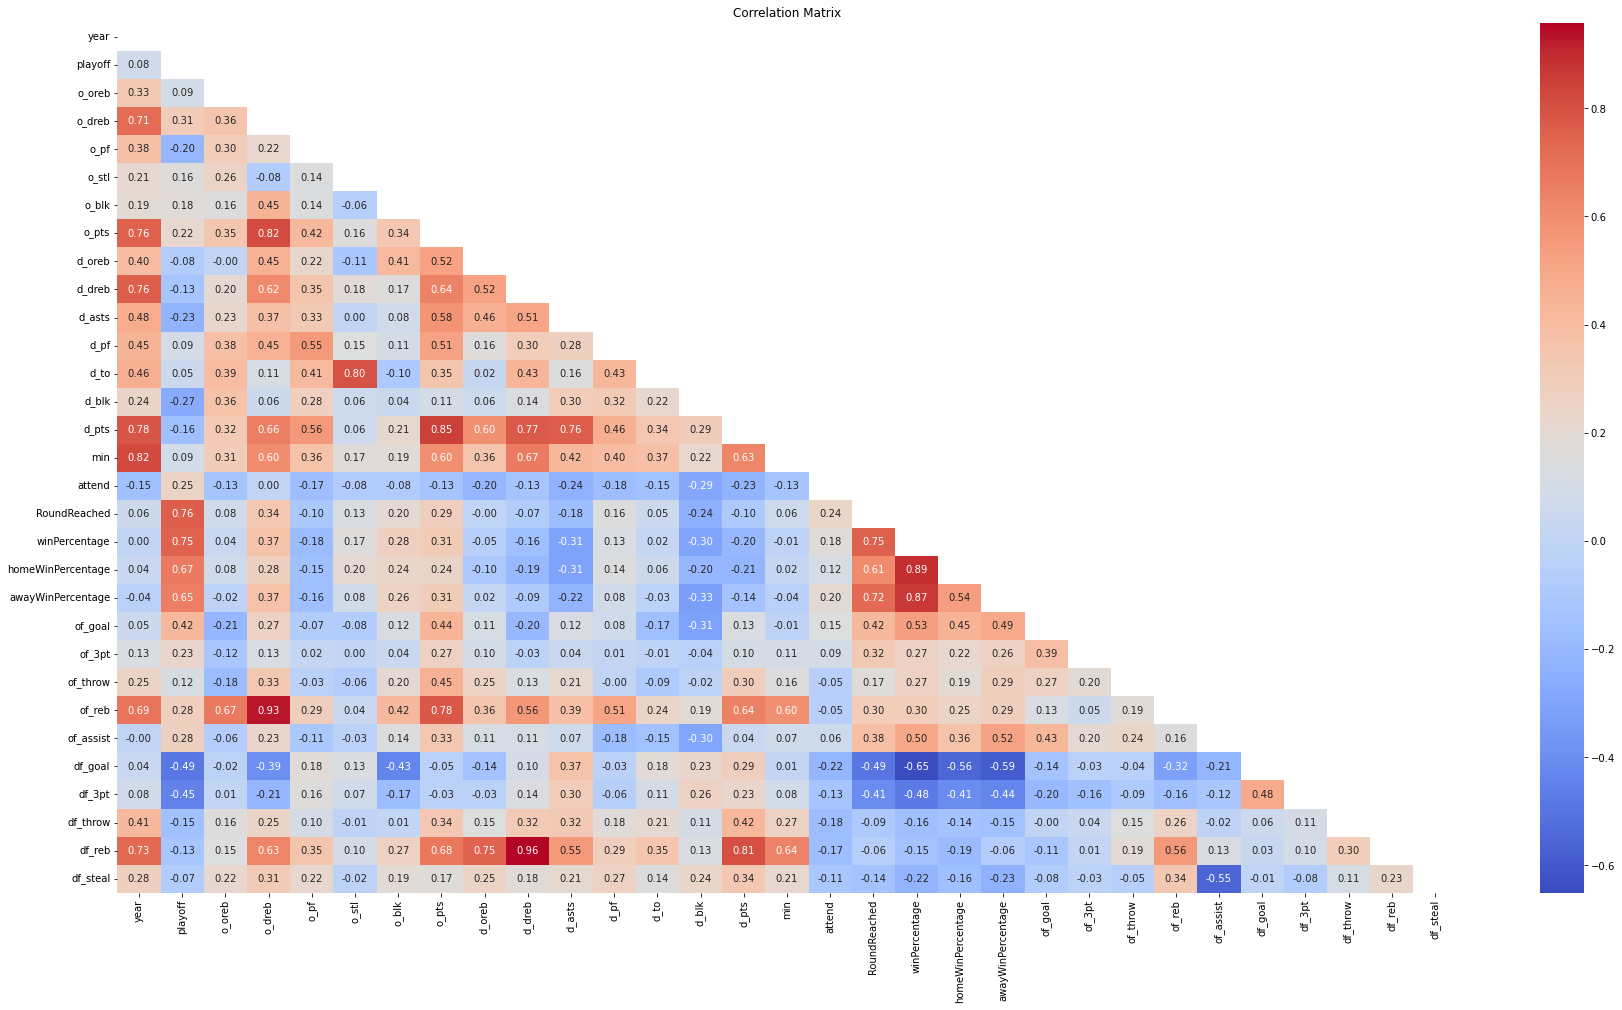

Number of correlation values greater than 0.7: 22
Number of correlation values lower than -0.7: 0

Correlation matrix for Coaches


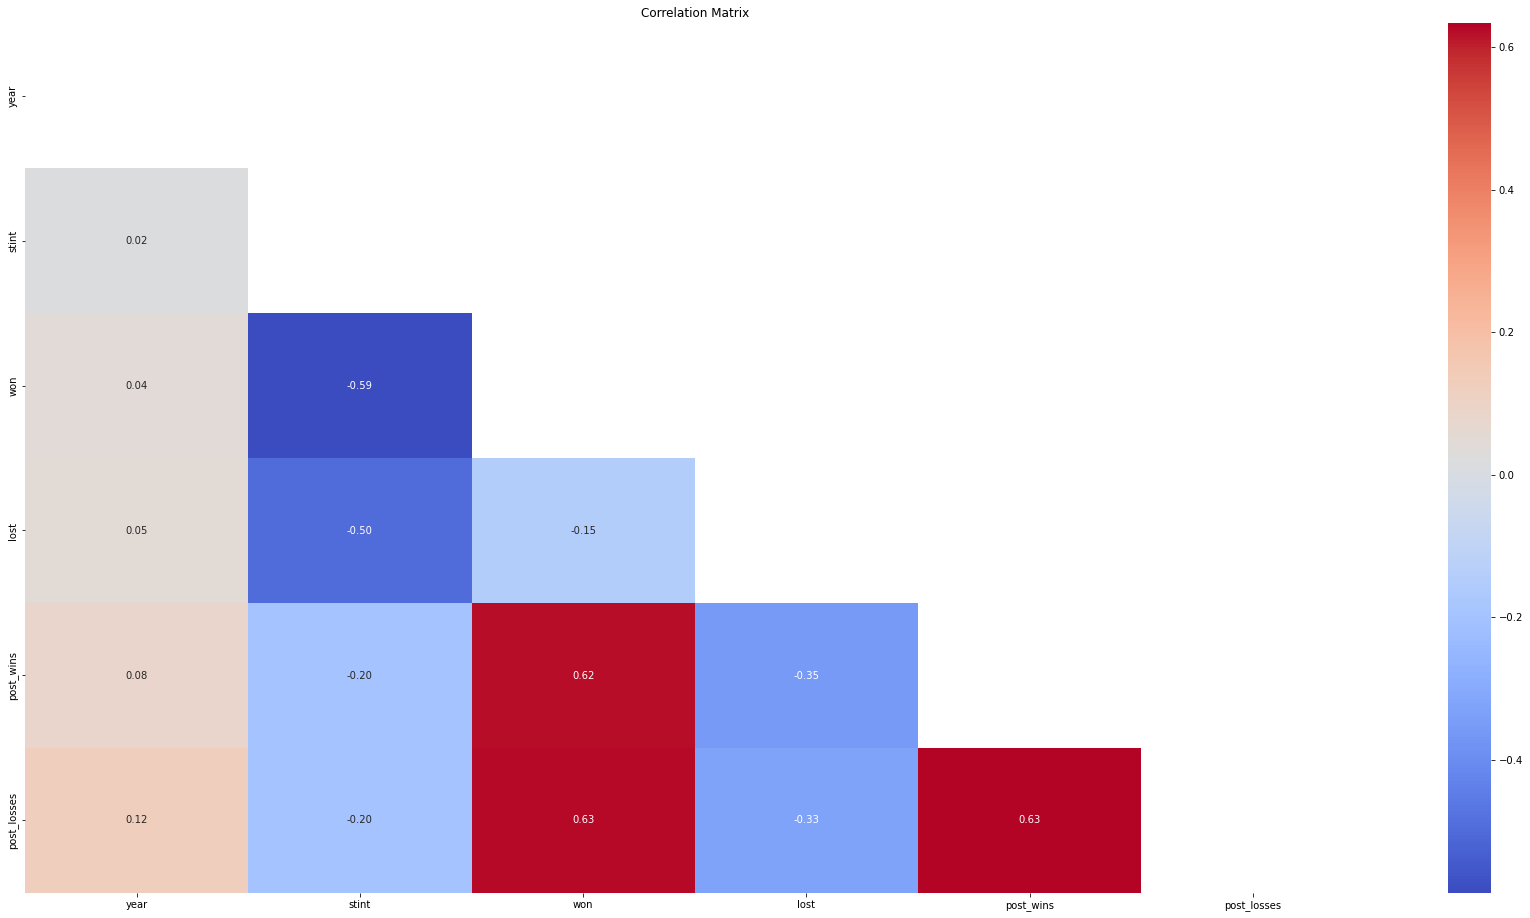

Number of correlation values greater than 0.7: 0
Number of correlation values lower than -0.7: 0

Correlation matrix for Players


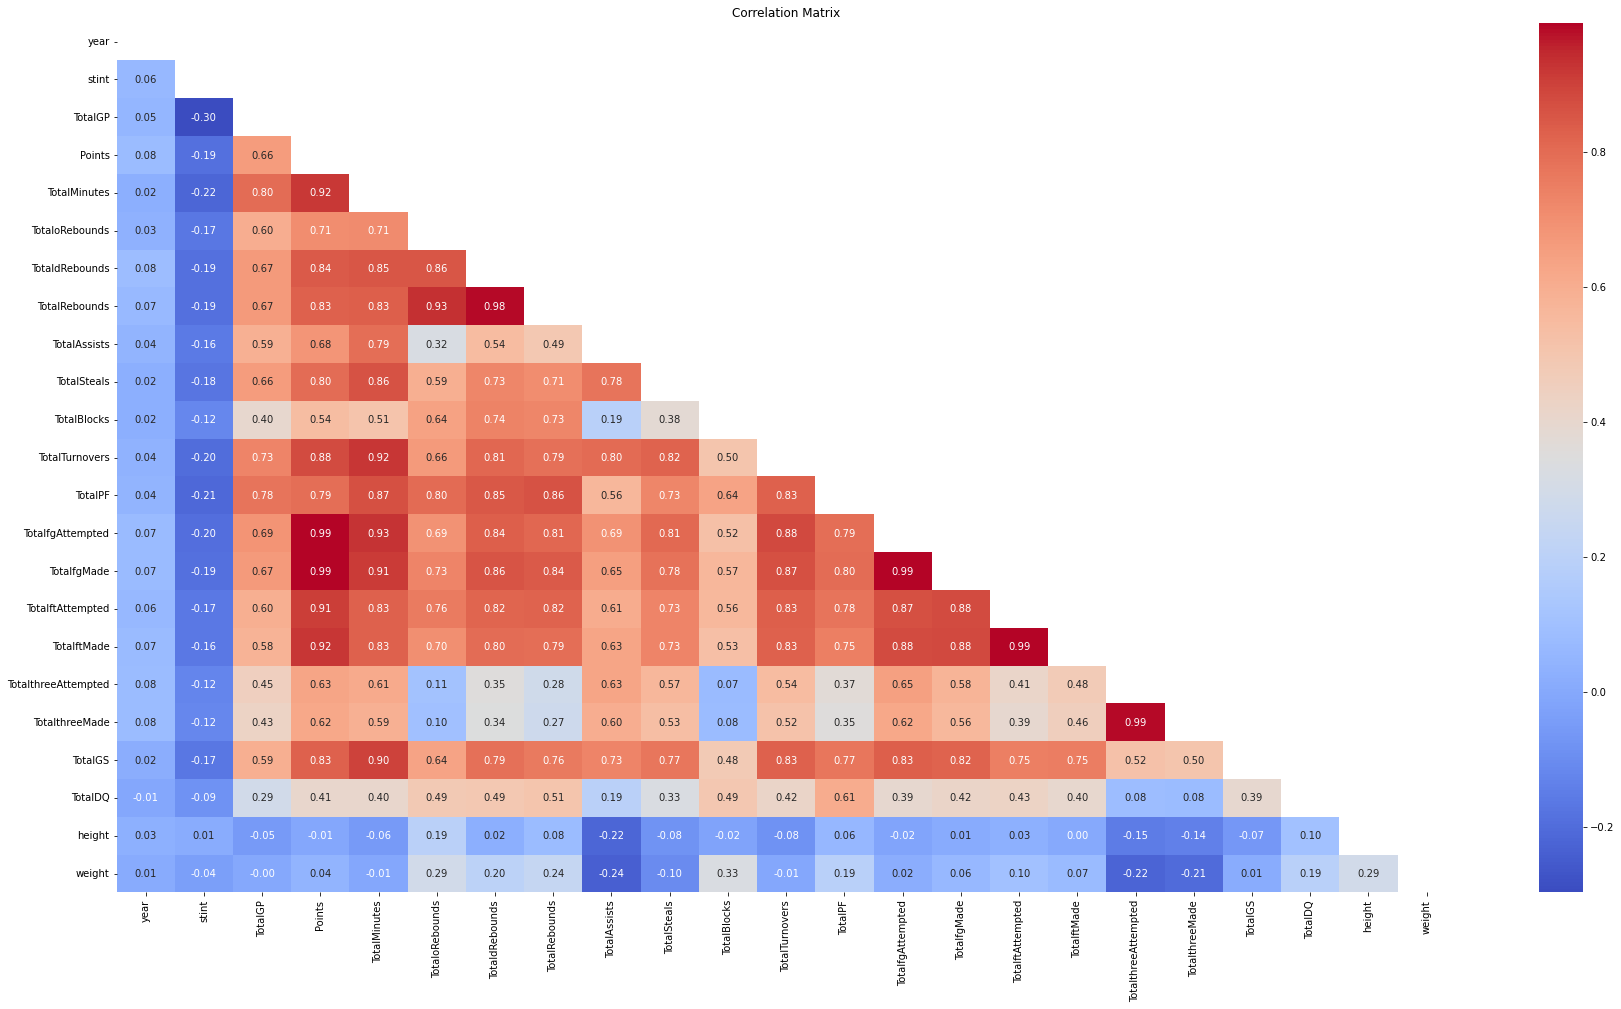

Number of correlation values greater than 0.7: 84
Number of correlation values lower than -0.7: 0


In [162]:
# Looking for correlations between attributes in each df

for i, df in enumerate(df_list_cleaned):
    num = df.select_dtypes(include=['number'])
    if len(num.columns) > 3:
        print(f"\nCorrelation matrix for {df_names[i]}")
        show_corr_matrix(df)


Looking at the df_teams dataframe and using the df_players to get player combined stats, in a abridged form, we can see the teams stats over the 10 years of data we have.

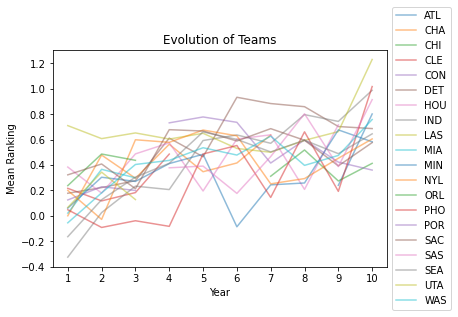

In [149]:
df_pred = player_rankings(df_players)
df_players_teams = player_in_team_by_year(df_players)
df_players_teams = team_mean(df_players_teams, df_pred)

df_teams_evolution = df_players_teams.groupby(['tmID', 'year']).agg({
    'mean': 'mean'
}).reset_index()


df_teams_evolution = df_teams_evolution.pivot(
    index='year', columns='tmID', values='mean')

df_teams_evolution.plot(kind='line', stacked=False, alpha=0.5)

# Set the title and axis labels
plt.title('Evolution of Teams')
plt.xlabel('Year')
plt.ylabel('Mean Ranking')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(df_teams_evolution.index)
plt.show()


Important to note that there are teams that have changed names, confederation or just ended (lines that don't span over the 10 years) over the years, so we will need to account for that.